# **Jurnal Modul 2**
## (Equalisasi dan Spesifikasi)
### Rizki Rahman Maulana

#### **Mengimport library**

In [21]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt



Terlebih dahulu lakukan import library numpy untuk melakukan operasi numerik , cv2 untuk melakukan pengolahan citra dan matplotlib untuk visualisasi data.

#### **Menginisaliasi Fungsi-fungsi**

In [20]:
def transalasi(image, geser): #geser mewakili jumlah pergeseran
    tinggi, lebar = image.shape[:2]
    imagenew = np.zeros((tinggi, lebar)).astype(int) #inisialisi imagenew ke array nol terlebih dahulu

    for y in range(0, 207): #perulangan 0 - 206
        for x in range(200, 820): #loop bersarang 200-820
            if not 0 <= image[y, x] <= 20: #apakah tidak di rentang 0-20?
                imagenew[y + geser , x] = image[y, x] #jika iya, pergeseran vertikal sebesar 'geser'

    for y in range(800, tinggi): #800 - tinggi gambar
        for x in range(200, 820): 
            if not 0 <= image[y, x] <= 20: 
                imagenew[y - geser , x ] = image[y, x]#jika iya, pergeseran vertikal sebesar '- geser'

    for y in range(300, 720):
        for x in range(0, 210):
            if not 0 <= image[y, x] <= 20:
                imagenew[y, x + geser] = image[y, x]#jika iya, pergeseran horizontal sebesar ' geser'

    for y in range(300, 720):
        for x in range(820, lebar):
            if not 0 <= image[y, x] <= 20:
                imagenew[y, x - geser] = image[y, x]#jika iya, pergeseran horizontal sebesar '- geser'

    return imagenew

def cropedImage(image):
    # new_image = image[309:720, 213:812]
    new_image = image[215:812, 309:718] 
    #[215:812] menentukan rentang baris (tinggi) 
    #[309:718] menentukan rentang kolom (lebar) yang dipilih
    return new_image

def rotate(image, angle):
    tinggi, lebar = image.shape
    rad = angle*(np.pi/180) #simpan sudut rotasi dalam radian
    
    # Hitung ukuran gambar hasil rotasi
    tengahx = tinggi // 2 #koordinat titik tengah x
    tengahy = lebar // 2 #koordinat titik tengah y
    #ukuran gambar hasil rotasi
    xnew = tinggi 
    ynew = lebar 
    
    rotate_image = np.zeros((xnew, ynew)) #membuat array kosong untuk menampung hasil nilai
    
    for i in range(tinggi):
        for j in range(lebar):
            # Menghitung koordinat baru setiap piksel setelah rotasi
            x = int((i - tengahx) * np.cos(rad) - (j - tengahy) * np.sin(rad) + tengahx)
            y = int((i - tengahx) * np.sin(rad) + (j - tengahy) * np.cos(rad) + tengahy)
            
            # Pastikan koordinat baru berada dalam rentang gambar hasil rotasi
            if 0 <= x < xnew and 0 <= y < ynew:
                rotate_image[x, y] = image[i, j]
    return rotate_image

def compute_histogram(image):
    histogram = np.zeros(256) #membuat array kosong dengan nilai 256
    for pixel_value in np.nditer(image): 
        histogram[int(pixel_value)] += 1 #Menambahkan 1 ke bin histogram yang sesuai dengan nilai piksel saat ini
    return histogram

\
def compute_cdf(histogram): #menghitung cumulative distribution function (CDF)
    cdf = np.zeros(256) #membuat array kosong cdf dengan panjang 256
    cdf[0] = histogram[0] #menetapkan nilai CDF untuk bin pertama
    for i in range(1, 256):
        cdf[i] = cdf[i-1] + histogram[i]
    return  cdf / cdf.max()


def equalisasi(image):
    histogram = compute_histogram(image)
    cdf = compute_cdf(histogram)
    
    # Normalisasi CDF agar berada dalam rentang [0, 255]
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    
    # Menggunakan CDF yang sudah dinormalisasi untuk melakukan transformasi equalisasi
    equalisasi_image = cdf_normalized[image.astype(int)]
    
    return equalisasi_image.astype(np.uint8)

def histogram_specification(image, target_image):
    # menghitung histogram
    target_hist = compute_histogram(image)
    ref_hist = compute_histogram(target_image)

    # Hitung CDF dari histogram
    target_cdf = compute_cdf(target_hist)
    ref_cdf = compute_cdf(ref_hist)

    # Create the mapping
    mapping = np.zeros(256)# array kosong mapping dengan panjang 256
    for i in range(256):
        # Find the closest value in ref_cdf to target_cdf[i]
        idx = np.abs(ref_cdf - target_cdf[i]).argmin()
        mapping[i] = idx

    #  menggunakan mapping yang telah dibuat untuk mengubah nilai piksel dalam gambar image
    specified_image = mapping[image.astype(np.uint8)]
    
    return specified_image.astype(np.uint8)

def match_histograms(source_image, reference_image):
    # Hitung histogram dan CDF dari gambar sumber
    source_hist, source_bins = np.histogram(source_image.flatten(), bins=256, range=(0, 256), density=True) #histogram dari gambar sumber (source_image)
    # (CDF) dari histogram gambar sumber dihitung
    source_cdf = source_hist.cumsum()
    source_cdf = (255 * source_cdf / source_cdf[-1]).astype(np.uint8)

    # Sama juga, Hitung histogram dan CDF dari gambar referensi
    reference_hist, reference_bins = np.histogram(reference_image.flatten(), bins=256, range=(0, 256), density=True)
    reference_cdf = reference_hist.cumsum()
    reference_cdf = (255 * reference_cdf / reference_cdf[-1]).astype(np.uint8)

    # Buat pemetaan dari nilai piksel sumber ke referensi
    pixel_mapping = np.zeros(256, dtype=np.uint8) #array kosong pixel_mapping dengan panjang 256
    #membuat pemetaan (mapping) antara nilai CDF dari gambar sumber dan nilai CDF dari gambar referensi
    for pixel_value in range(256):
        closest_idx = np.searchsorted(reference_cdf, source_cdf[pixel_value])
        pixel_mapping[pixel_value] = closest_idx

    # Terapkan pemetaan ke gambar sumber untuk mendapatkan gambar yang disesuaikan
    matched_image = pixel_mapping[source_image.astype(np.uint8)].reshape(source_image.shape)
    return matched_image

Code diatas adalah beberapa fungsi-fungsi yang menyediakan atau menginisialiasi pemrosesas citra pada modul 2, diantaranya yaitu translasi, pemotongan, rotasi, equalisasi, histogram, spesifikasi histogram, dan pencocokan histogram antara dua gambar.

### **NOMOR 1**

#### **Memotong Gambar Utama menjadi 2*2**

Sebelum melakukan pemotongan, terlebih dahulu menampilkan gambar utama yang akan di potong.

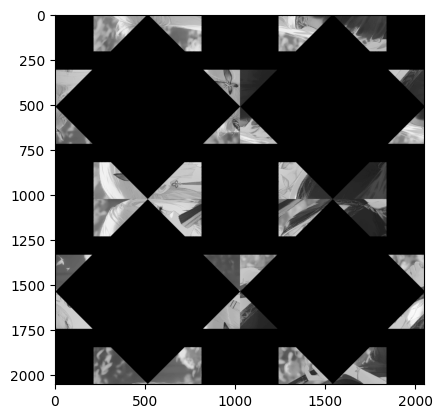

In [4]:
senheScramble = plt.imread("senheScramble.jpg")
plt.imshow(senheScramble, cmap='gray') 

Lalu, kode berikut membagi gambar senheScramble menjadi empat bagian yang sama ukurannya. Bagian-bagian ini ditampilkan dalam subplot dengan menggunakan plt.imshow dengan skala warna keabuan.

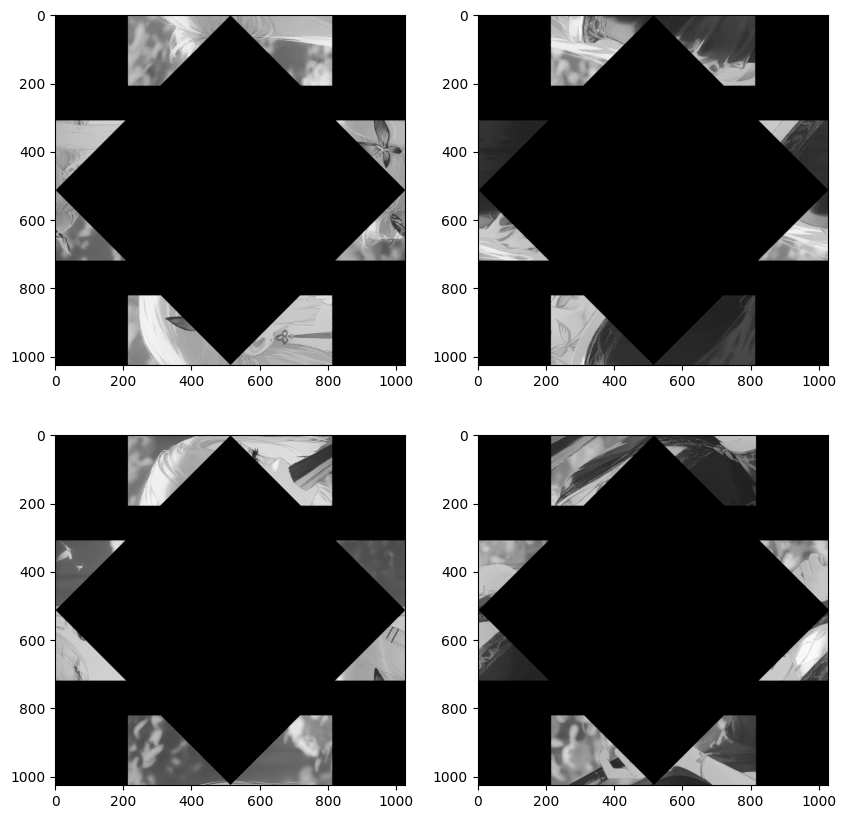

In [5]:
tinggi, lebar = senheScramble.shape[:2]
shenheScramble1 = senheScramble[:tinggi//2, :lebar//2]
shenheScramble2 = senheScramble[:tinggi//2, lebar//2:]
shenheScramble3 = senheScramble[tinggi//2:, :lebar//2]
shenheScramble4 = senheScramble[tinggi//2:, lebar//2:]
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(shenheScramble1, cmap="gray")
plt.subplot(222)
plt.imshow(shenheScramble2, cmap="gray")
plt.subplot(223)
plt.imshow(shenheScramble3, cmap="gray")
plt.subplot(224)
plt.imshow(shenheScramble4, cmap="gray")

Setelah melakukan pemrosesan pemotongan gambar utama, maka kita perlu melakukan pemrosesan citra untuk setiap potongan tersebut. Untuk itu dibagi menjadi beberapa sub.

#### **Operasi Sub Gambar 1**

 Lakukan operasi pemrosesan gambar Sub Gambar 1 yaitu shenheScramble1. Gambar tersebut dijalani melalui fungsi transalasi dengan parameter geser sebesar 513. Kemudian, gambar tersebut diputar sebesar -90 derajat dengan menggunakan fungsi rotate, dan hasil rotasi ditampilkan dalam subplot ketiga. Terakhir, gambar tersebut dipotong menggunakan fungsi cropedImage dan hasil potongan ditampilkan dalam subplot keempat.

(1026, 1026)
(1026, 1026)


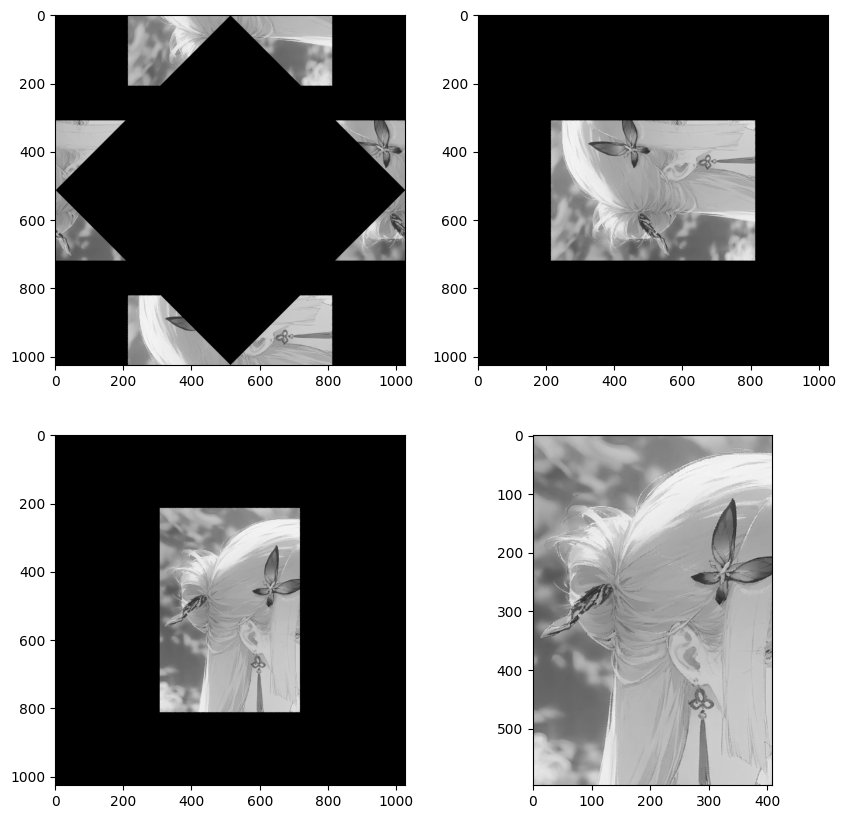

In [6]:
transalasiimg1 = transalasi(shenheScramble1, 513)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(shenheScramble1, cmap="gray")
plt.subplot(222)
plt.imshow(transalasiimg1, cmap="gray")
print(transalasiimg1.shape)
rotated1image = rotate(transalasiimg1, -90)
plt.subplot(223)
plt.imshow(rotated1image, cmap="gray")
crop1image = cropedImage(rotated1image)
print(rotated1image.shape)
plt.subplot(224)
plt.imshow(crop1image, cmap="gray")



#### **Operasi Sub Gambar 2**

 Lakukan juga operasi pemrosesan gambar Sub Gambar 2 yaitu shenheScramble2. Gambar tersebut dijalani melalui fungsi transalasi dengan parameter geser sebesar 513. Kemudian, gambar tersebut diputar sebesar -90 derajat dengan menggunakan fungsi rotate, dan hasil rotasi ditampilkan dalam subplot ketiga. Terakhir, gambar tersebut dipotong menggunakan fungsi cropedImage dan hasil potongan ditampilkan dalam subplot keempat.

(1026, 1026)
(1026, 1026)


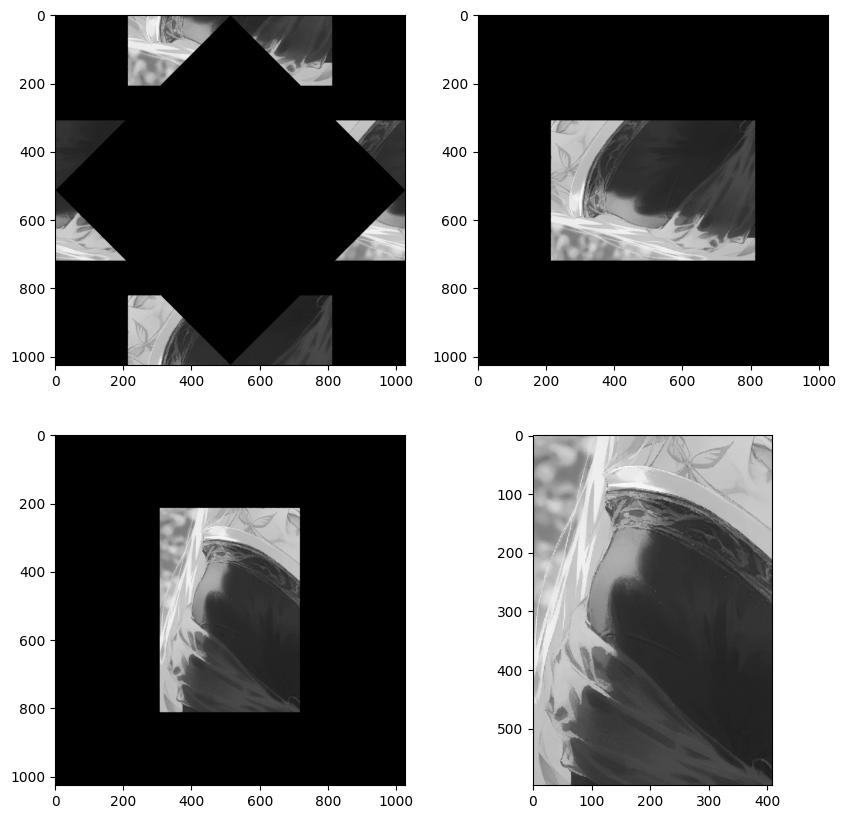

In [7]:
transalasiimg2 = transalasi(shenheScramble2, 513)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(shenheScramble2, cmap="gray")
plt.subplot(222)
plt.imshow(transalasiimg2, cmap="gray")
print(transalasiimg2.shape)
rotated2image = rotate(transalasiimg2, -90)
plt.subplot(223)
plt.imshow(rotated2image, cmap="gray")
crop2image = cropedImage(rotated2image)
print(rotated2image.shape)
plt.subplot(224)
plt.imshow(crop2image, cmap="gray")



#### **Operasi Sub Gambar 3**

 Lakukan operasi pemrosesan gambar Sub Gambar 3 yaitu shenheScramble3. Gambar tersebut dijalani melalui fungsi transalasi dengan parameter geser sebesar 513. Kemudian, gambar tersebut diputar sebesar -90 derajat dengan menggunakan fungsi rotate, dan hasil rotasi ditampilkan dalam subplot ketiga. Terakhir, gambar tersebut dipotong menggunakan fungsi cropedImage dan hasil potongan ditampilkan dalam subplot keempat.

(1026, 1026)
(1026, 1026)


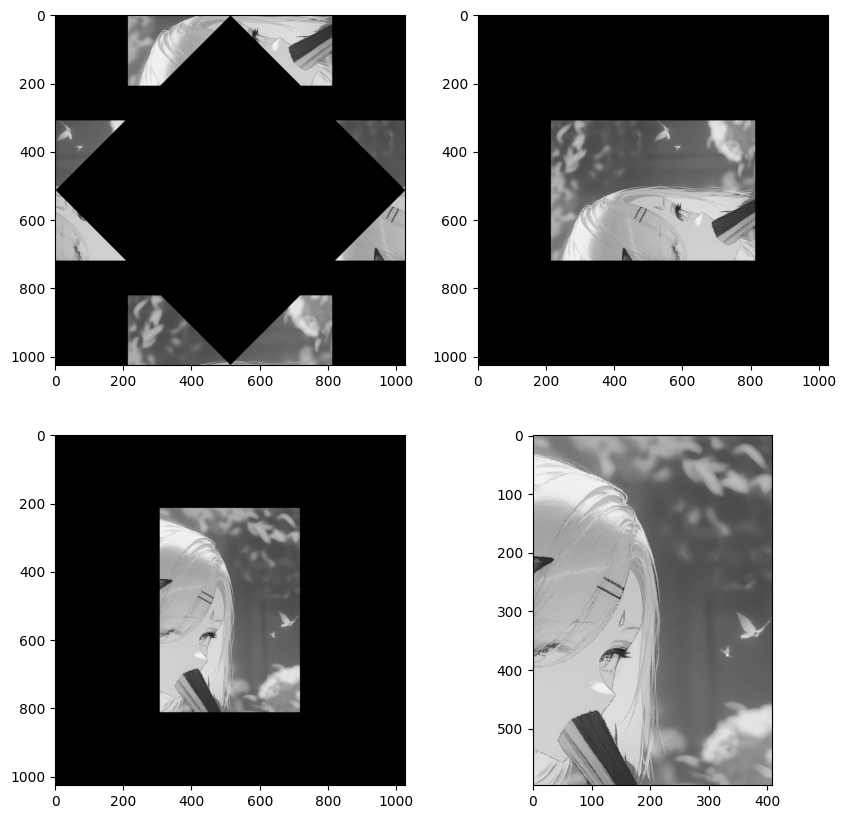

In [8]:
transalasiimg3 = transalasi(shenheScramble3, 513)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(shenheScramble3, cmap="gray")
plt.subplot(222)
plt.imshow(transalasiimg3, cmap="gray")
print(transalasiimg3.shape)
rotated3image = rotate(transalasiimg3, -90)
plt.subplot(223)
plt.imshow(rotated3image, cmap="gray")
crop3image = cropedImage(rotated3image)
print(rotated3image.shape)
plt.subplot(224)
plt.imshow(crop3image, cmap="gray")



#### **Operasi Sub Gambar 4**

 Lakukan operasi pemrosesan gambar Sub Gambar 4 yaitu shenheScramble4. Gambar tersebut dijalani melalui fungsi transalasi dengan parameter geser sebesar 513. Kemudian, gambar tersebut diputar sebesar -90 derajat dengan menggunakan fungsi rotate, dan hasil rotasi ditampilkan dalam subplot ketiga. Terakhir, gambar tersebut dipotong menggunakan fungsi cropedImage dan hasil potongan ditampilkan dalam subplot keempat.

(1026, 1026)
(1026, 1026)


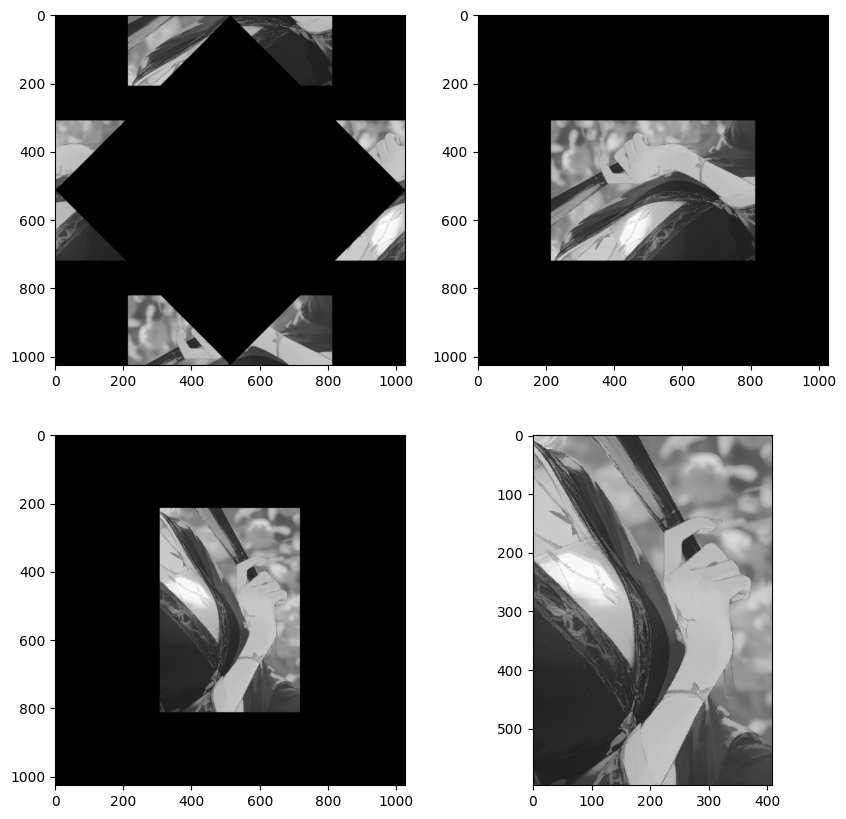

In [9]:
transalasiimg4 = transalasi(shenheScramble4, 513)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(shenheScramble4, cmap="gray")
plt.subplot(222)
plt.imshow(transalasiimg4, cmap="gray")
print(transalasiimg4.shape)
rotated4image = rotate(transalasiimg4, -90)
plt.subplot(223)
plt.imshow(rotated4image, cmap="gray")
crop4image = cropedImage(rotated4image)
print(rotated4image.shape)
plt.subplot(224)
plt.imshow(crop4image, cmap="gray")



#### **Kombinasi Semua Sub Gambar**

Setelah melakukan beberapa proses pada sub-sub nya. Setiap bagian gambar diposisikan sesuai dengan koordinatnya dalam gambar gabungan, lalu digabungkan menggunakan operator slicing. Hal ini untuk menyelesaikan nomor-nomor selanjutnya. 

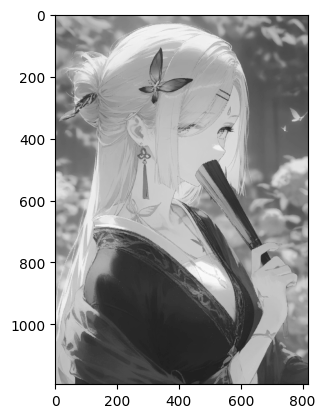

In [10]:
combined_image = np.zeros((crop1image.shape[0] * 2, crop1image.shape[1] * 2))

combined_image[:crop1image.shape[0], :crop1image.shape[1]] = crop1image
combined_image[crop1image.shape[0]:, :crop1image.shape[1]] = crop2image
combined_image[:crop1image.shape[0], crop1image.shape[1]:] = crop3image
combined_image[crop1image.shape[0]:, crop1image.shape[1]:] = crop4image

# Menampilkan gambar yang telah digabungkan
plt.imshow(combined_image, cmap="gray")
plt.show()

## **NOMOR 2**

#### **Equalisasi Gambar Kombinasi**

Kode ini melakukan equalisasi histogram pada gambar yang telah digabungkan (combined_image). Hasilnya ditampilkan dalam beberapa subplot.

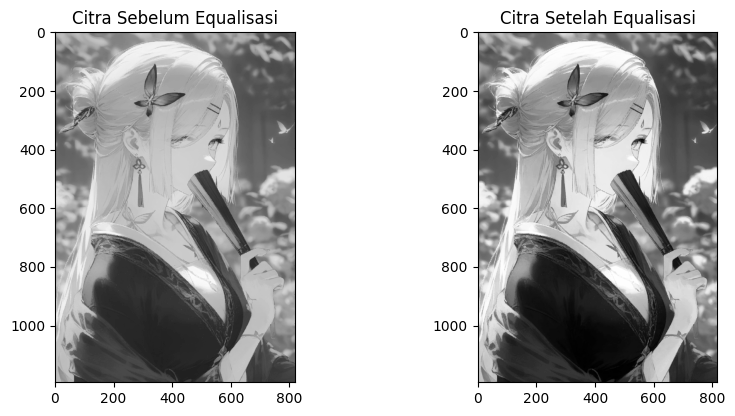

In [11]:
equalisasi_image = equalisasi(combined_image)
hist_sebelum = compute_histogram(combined_image)
hist_setelah = compute_histogram (equalisasi_image)
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.imshow(combined_image, cmap="gray")
plt.title('Citra Sebelum Equalisasi')

plt.subplot(222)
plt.imshow(equalisasi_image, cmap="gray")
plt.title('Citra Setelah Equalisasi')

plt.show()

#### **Perbandingan Histogram Sebelum dan Sesudah Equalisasi**

 Setelah itu, menampilkan histogram sebelum dan sesudah proses equalisasi. Hal ini untuk melihat perbedaan histogram nya.

Text(0.5, 1.0, 'Histogram Setelah Equalisasi')

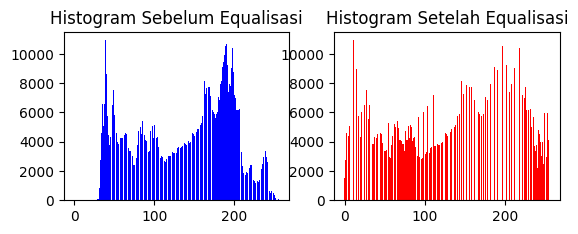

In [19]:
plt.subplot(223)
plt.bar(np.arange(256), hist_sebelum, color='b')
plt.title('Histogram Sebelum Equalisasi')

plt.subplot(224)
plt.bar(np.arange(256), hist_setelah, color='r')
plt.title('Histogram Setelah Equalisasi')

## **NOMOR 3**

#### **Spesifikasi Image**

Pada nomor 3 kita melakukan spesifikasi histogram pada gambar yang telah di-equalisasi (equalisasi_image) menggunakan citra referensi (kurumi_image). 

Text(0.5, 1.0, 'Citra Hasil Spesifikasi')

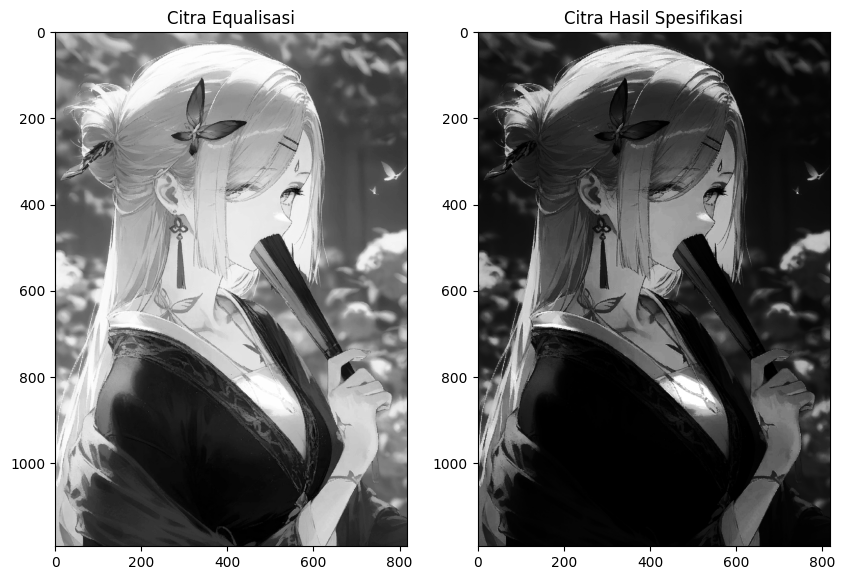

In [12]:
kurumi_image = plt.imread('kurumi.jpg')
spesifikasi1_image = histogram_specification(equalisasi_image, kurumi_image)
hist_spesifikasi1 = compute_histogram(spesifikasi1_image)
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(equalisasi_image, cmap="gray")
plt.title('Citra Equalisasi')

# Display the resulting image
plt.subplot(122)
plt.imshow(spesifikasi1_image, cmap='gray')
plt.title('Citra Hasil Spesifikasi')

Selain melakukan spesifikasi pada 'kurumi_image', kita juga diperintahkan untuk melakukan spesifikasi pada 'megumin_image'.

Text(0.5, 1.0, 'Citra Hasil Spesifikasi')

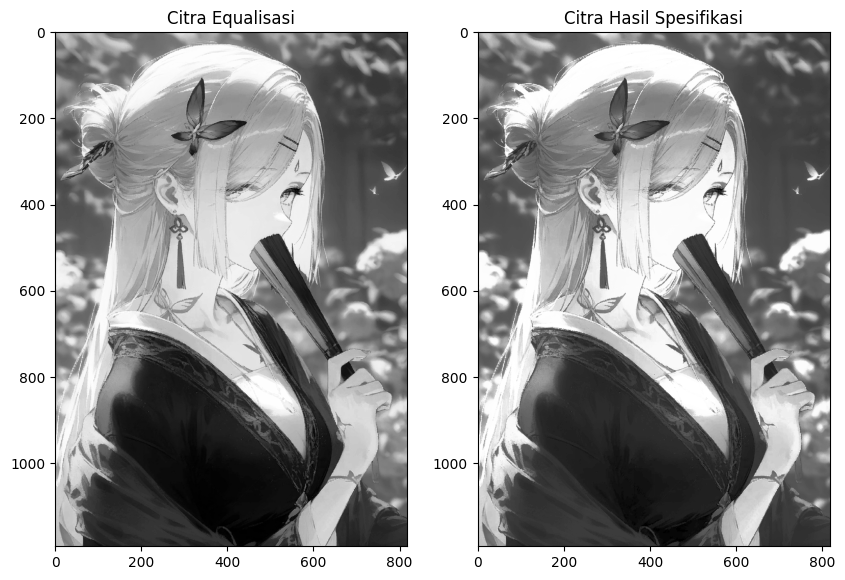

In [13]:
megumin_image = plt.imread('megumin.jpg')
spesifikasi2_image = histogram_specification(equalisasi_image, megumin_image)
hist_spesifikasi2 = compute_histogram(spesifikasi2_image)
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(equalisasi_image, cmap="gray")
plt.title('Citra Equalisasi')

# Display the resulting image
plt.subplot(122)
plt.imshow(spesifikasi2_image, cmap='gray')
plt.title('Citra Hasil Spesifikasi')

Dari proses spesifikasi diatas, dapat dianalisis bahwa hasil spesifikasi mengikuti intensitas piksel dari target image yang digunakan, pada target image kurumi intensita piksel gelap lebih dominan sehingga citra asli akan mengikuti target begitupun sebaliknya.

## **NOMOR 4 & 5**

#### **Spesifikasi Pecahan Gambar**

Terlebih dahulu menginisialisasi image yang akan digunakan yakni hasil equalisasi.

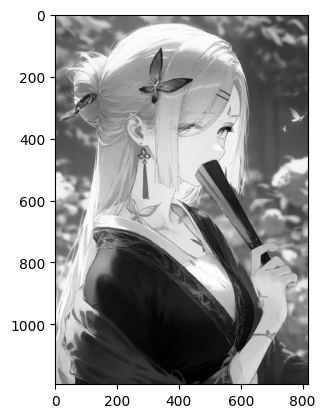

In [14]:
plt.imshow(equalisasi_image, cmap='gray')

##### *Pecahan 1 * 2*

Yang pertama melakukan pemotongan gambar hasil equalisasi dengan ukuran 1*2, yaitu crop1x21 dan crop1x22. Kemudian, nilai rata-rata piksel dihitung untuk kedua bagian tersebut. Citra referensi (kurumi/megumi) untuk spesifikasi histogram ditentukan berdasarkan nilai rata-rata piksel, dan fungsi spesifikasi histogram manual diterapkan pada setiap bagian. Bagian yang telah disesuaikan digabungkan dan ditampilkan.

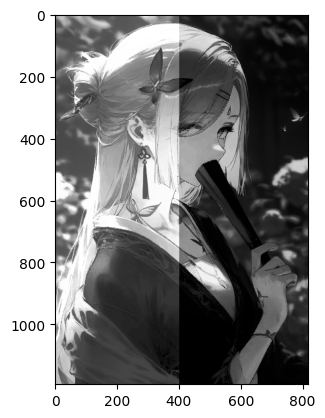

In [15]:

crop1x21 = equalisasi_image[:,:400]
crop1x22 = equalisasi_image[:,400:]

# Menghitung nilai rata-rata piksel untuk setiap pecahan
mean_pixel_value_crop1 = np.mean(crop1x21)
mean_pixel_value_crop2 = np.mean(crop1x22)

# Menentukan citra referensi untuk spesifikasi histogram berdasarkan rata-rata piksel
reference_image_crop1 = kurumi_image if mean_pixel_value_crop1 <= 128 else megumin_image
reference_image_crop2 = kurumi_image if mean_pixel_value_crop2 <= 128 else megumin_image

# Menerapkan fungsi spesifikasi histogram manual ke setiap bagian
specified_crop1_manual = match_histograms(crop1x21, reference_image_crop1)
specified_crop2_manual = match_histograms(crop1x22, reference_image_crop2)

# Menggabungkan bagian yang telah disesuaikan
combined_specified_manual = np.hstack((specified_crop1_manual, specified_crop2_manual))

plt.imshow(combined_specified_manual, cmap='gray')
plt.show()


##### *Pecahan 2 * 2*

Lalu yang kedua melakukan pemotongan hasil equalisasi dengan ukuran 2*2 , yaitu crop2x21, crop2x22, crop2x23, dan crop2x24. Nilai rata-rata piksel dihitung untuk setiap bagian tersebut, dan citra referensi untuk spesifikasi histogram ditentukan berdasarkan nilai rata-rata piksel. Fungsi spesifikasi histogram manual kemudian diterapkan pada setiap bagian, dan bagian yang telah disesuaikan digabungkan kembali menjadi konfigurasi gambar 2x2. Gambar hasil akhir ditampilkan.

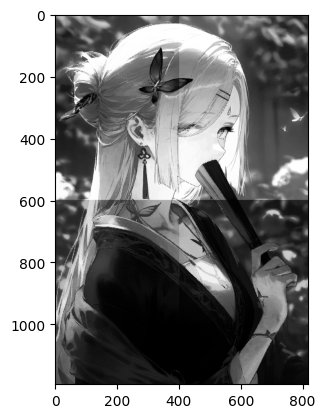

In [22]:
crop2x21 = equalisasi_image[:600, :400]
crop2x22 = equalisasi_image[:600, 400:]
crop2x23 = equalisasi_image[600:, :400]
crop2x24 = equalisasi_image[600:, 400:]

# Menghitung nilai rata-rata piksel untuk setiap pecahan
mean_pixel_value_crop1 = np.mean(crop2x21)
mean_pixel_value_crop2 = np.mean(crop2x22)
mean_pixel_value_crop3 = np.mean(crop2x23)
mean_pixel_value_crop4 = np.mean(crop2x24)

# Menentukan citra referensi untuk spesifikasi histogram berdasarkan rata-rata piksel
reference_image_2x21 = kurumi_image if mean_pixel_value_crop1 <= 128 else megumin_image
reference_image_2x22 = kurumi_image if mean_pixel_value_crop2 <= 128 else megumin_image
reference_image_2x23 = kurumi_image if mean_pixel_value_crop3 <= 128 else megumin_image
reference_image_2x24 = kurumi_image if mean_pixel_value_crop4 <= 128 else megumin_image

# Apply the manual histogram specification function to each part
specified_2x21 = match_histograms(crop2x21, reference_image_2x21)
specified_2x22 = match_histograms(crop2x22, reference_image_2x22)
specified_2x23 = match_histograms(crop2x23, reference_image_2x23)
specified_2x24 = match_histograms(crop2x24, reference_image_2x24)

# Combine the specified parts back into a 2x2 image configuration
combined_2x2_top = np.hstack((specified_2x21, specified_2x22))
combined_2x2_bottom = np.hstack((specified_2x23, specified_2x24))
combined_2x2 = np.vstack((combined_2x2_top, combined_2x2_bottom))

plt.imshow(combined_2x2, cmap='gray')
plt.show()


##### *Pecahan 2 * 16*

Lalu, yang ketiga membagi gambar equalisasi dengan ukuran 2*16 bagian, kemudian melakukan spesifikasi histogram manual untuk setiap bagian berdasarkan citra referensi yang dipilih berdasarkan rata-rata piksel. Bagian yang telah disesuaikan kemudian digabungkan kembali menjadi konfigurasi gambar 2x16, yang kemudian ditampilkan.

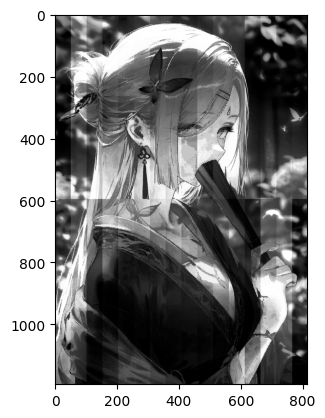

In [17]:
parts = []
for i in range(2):
    for j in range(16):
        part = equalisasi_image[i * (equalisasi_image.shape[0] // 2): (i + 1) * (equalisasi_image.shape[0] // 2),
                               j * (equalisasi_image.shape[1] // 16): (j + 1) * (equalisasi_image.shape[1] // 16)]
        parts.append(part)

# Match histograms for each part
specified_parts = []
for part in parts:
    # Calculate mean pixel value for each part
    mean_pixel_value = np.mean(part)

    # Determine reference image for histogram specification based on mean pixel value
    reference_image = kurumi_image if mean_pixel_value <= 128 else megumin_image

    # Apply the manual histogram specification function to the part
    specified_part = match_histograms(part, reference_image)
    specified_parts.append(specified_part)

# Reshape specified parts for correct arrangement
specified_parts = [specified_parts[i:i+16] for i in range(0, len(specified_parts), 16)]

# Combine the specified parts into a 2x16 image configuration
combined_rows = [np.hstack(row_parts) for row_parts in specified_parts]
combined_2x16 = np.vstack(combined_rows)

# Visualize the combined 2x16 image
plt.imshow(combined_2x16, cmap='gray')
plt.show()

##### *Pecahan 16 * 16*

Yang terakhir yaitu membagi gambar equalisasi menjadi 16*16 bagian, kemudian melakukan spesifikasi histogram manual untuk setiap bagian berdasarkan citra referensi yang dipilih berdasarkan rata-rata piksel. Bagian yang telah disesuaikan kemudian digabungkan kembali menjadi konfigurasi gambar 16x16, yang kemudian ditampilkan.

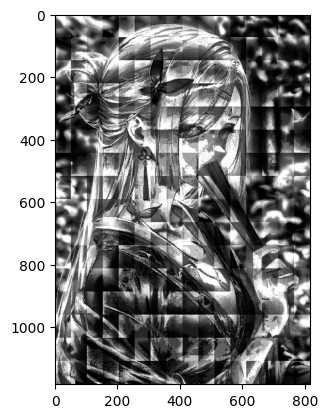

In [18]:
parts = []
for i in range(16):
    for j in range(16):
        part = equalisasi_image[i * (equalisasi_image.shape[0] // 16): (i + 1) * (equalisasi_image.shape[0] // 16),
                               j * (equalisasi_image.shape[1] // 16): (j + 1) * (equalisasi_image.shape[1] // 16)]
        parts.append(part)

# Match histograms for each part
specified_parts = []
for part in parts:
    # Calculate mean pixel value for each part
    mean_pixel_value = np.mean(part)

    # Determine reference image for histogram specification based on mean pixel value
    reference_image = kurumi_image if mean_pixel_value <= 128 else megumin_image

    # Apply the manual histogram specification function to the part
    specified_part = match_histograms(part, reference_image)
    specified_parts.append(specified_part)

# Reshape specified parts for correct arrangement
specified_parts = [specified_parts[i:i+16] for i in range(0, len(specified_parts), 16)]

# Combine the specified parts into a 16x16 image configuration
combined_rows = [np.hstack(row_parts) for row_parts in specified_parts]
combined_16x16 = np.vstack(combined_rows)

plt.imshow(combined_16x16, cmap='gray')
plt.show()

Dari beberapa proses pada nomor 4, dapat disimpulkan bahwa semakin banyak ukuran baris dan kolom pada gambar maka semakin lama running time pada codingan.